# PROJET : GIVE ME SOME CREDIT

### Objectif

Améliorez l'état de l'art en matière de *notation de crédit* en ***prédisant la probabilité qu'une personne éprouve des difficultés financières au cours des deux prochaines années et ne rembourse pas son crédit***.


downloader de kaggle
"GiveMeSomeCredit" https://www.kaggle.com/c/GiveMeSomeCredit/overview

### Contexte

Les banques jouent un rôle crucial dans les économies de marché. Ils décident qui peut obtenir des financements et à quelles conditions et peuvent prendre ou arrêter des décisions d'investissement. Pour que les marchés et la société fonctionnent, les particuliers et les entreprises doivent avoir accès au crédit.

Les algorithmes de notation du crédit, qui permettent de deviner la probabilité de défaut, sont la méthode utilisée par les banques pour déterminer si un prêt doit être accordé ou non. 

Le but de ce projet est de construire un modèle que les emprunteurs peuvent utiliser pour prendre les meilleures décisions financières.

Des données historiques sont fournies sur 250 000 emprunteurs.

### Périmètre

Données issues de Kaggle de :
- 250 000 clients de banque
- 3 fichiers transmis :
  - 1 fichier training pour développer et améliorer le modèle
  - 1 fichier test pour tester le modèle réalisé
  - 1 fichier incluant le score / notation des clients (%)

## I/ DEFINITION DES OBJECTIFS (SMART)

- <b>Objectif</b> : Tenter de prédire / identifier les personnes qui seront en difficultés dans 2 ans à partir des données actuelles
- <b>Metrique</b> : 90% d'exactitude, R2 proche de 1, Pas d'Overfitting

------

# II/ EDA (EXPLORATY DATA ANALYSIS)

Objectif: comprendre au maximum les données dont on dispose pour définir une stratégie de modélisation.

 ## 1 - Analyse de la forme
- **Identification de la target** : "SeriousDlqin2yrs" 
  - 1 = défaut pendant plus de 90 jours au cours des deux dernières années
  - 0 = pas de défaut pendant plus de 90 jours au cours des deux dernières années
- **Nombre des lignes et de colonnes** : Training set (150000 lignes, 11 colonnes), Test set (101503 lignes, 11 colonnes) 
- **Identification des valeurs manquantes**
  - Il existe des valeurs manquantes 
    - MonthlyIncome (salaire mensuel) : 20% de valeurs manquantes
    - NumberOfDependents (nombre de personnes à charge) : 2% de valeurs manquantes
- **Types de variables**
  - Les variables sont de type Float et Int : Des variables numériques. Pas de variables catégoriques

## 2 - Analyse du fond:
- **Visualisation de la target (histogramme/boxplot/Valeurs statistiques)**
  - positive_df = 6% du dataset ont été en défaut durant les deux dernières années
  - negative_df = 94% ne sont pas en défaut
 
- **Compréhension des différentes variables (recherche)**
  - Variables de type float
    - RevolvingUtilizationOfUnsecuredLines: Un très grand nombre de client un très peu de disponibilité sur leur carte de crédit
    - DebtRatio : ratio majoritairement autour de la moyenne. Mais il existe des valeurs très élevées et éloinées des valeurs moyennes
    - 
    
- **Visualisation des relations (features/target)**
  - Ma matrice des corrélation indique une corrélation positive entre les défauts au bout de 2 années et le nombre de fois les incidents apparaissent (soit 30% au total). A cela, l'on pourrait rajouter le nombre de personnes à charge (NumberOfDependents) à raison de 4%
  - L'âge impact négativement le risque d'incident => plus l'âge croît, moins les clients sont susceptibles
            - age                                    -0.115001
            - NumberOfOpenCreditLinesAndLoans        -0.030126
            - MonthlyIncome                          -0.020472
            - NumberRealEstateLoansOrLines           -0.009846
            - DebtRatio                              -0.006274
            - RevolvingUtilizationOfUnsecuredLines   -0.003068
            - Probability                             0.005021
            - NumberOfDependents                      0.040088
            - NumberOfTime60-89DaysPastDueNotWorse    0.096983
            - NumberOfTimes90DaysLate                 0.111450
            - NumberOfTime30-59DaysPastDueNotWorse    0.119908
   - Les variables dont la corrélation inférieur à 1% seront enlevées de notre dataset (NumberRealEstateLoansOrLines, DebtRatio, RevolvingUtilizationOfUnsecuredLines, Probability) 
                   - => ***La notation interne n'est nullement corrélé avec le défaut du client dans 2 ans***      

- **Identification des outliers**
  - RevolvingUtilizationOfUnsecuredLines : présence de plusieurs outliers chez les clients dont le SeriousDlqin2yrs = 0

In [1]:
# Vous devez installer imblearn
## la commade pip install sous winddows telque mentionné ci-dessous
#pip install imblearn

In [2]:
#Import des livrairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

#Import des métrics
from sklearn.metrics import r2_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score


from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit,GridSearchCV

In [3]:

#import des fichier
dataset = pd.read_csv("cs-training.csv")
data_test = pd.read_csv("cs-test.csv")
data_score=pd.read_csv("sampleEntry.csv")

### Analyse de la forme des données

In [4]:
# Connaitre le nombre de lignes et de colonnes
dataset.shape

(150000, 12)

In [5]:
dataset.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


***Inclure les notation ou score des clients et suppression des colonnes non utiles*** (Id)

In [6]:
#jointure des dataset pour inclure le score
dataset= pd.merge(dataset, data_score, 
                  left_on='Unnamed: 0', right_on='Id',how='inner')

#suppression des colonnes inutiles
dataset=dataset.drop(columns =['Unnamed: 0','Id'],axis=1)

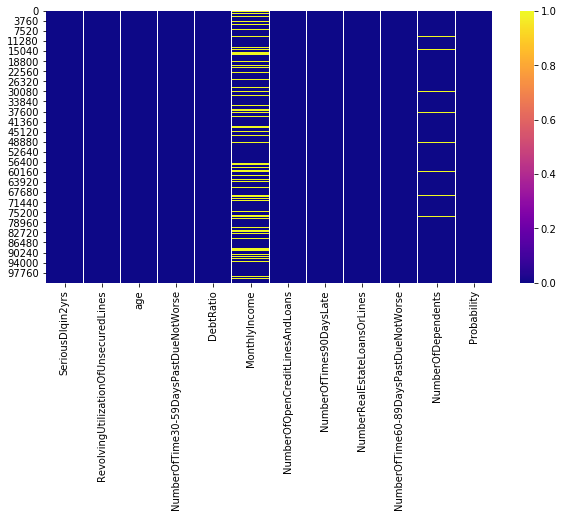

In [7]:
# Déterminer si le dataset contient des valeurs manquantes (gestion des valeurs manquantes)
## Voir s'il y a des valeurs manquantes
dataset.isnull().any()

# Gestion des valeurs manquantes
## connaitres le pourcentage des valeurs manquantes / triée avec l'attribut sort_values
(dataset.isnull().sum()/len(dataset)).sort_values(ascending=False)

# Visualisation des valeurs manquantes
## La taille de la figure peut être modifiée par exemple
plt.figure(figsize=(10,5))
sns.heatmap(dataset.isna(), cmap="plasma")

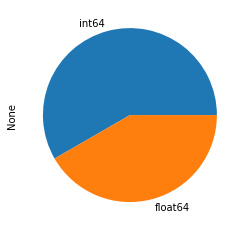

In [8]:
#Type de variables
dataset.dtypes.value_counts().plot.pie()

### Analyse du fond du dataset

***Information sur le dataset***

In [9]:
#Information sur le crédit
use_credit_card=dataset['RevolvingUtilizationOfUnsecuredLines']
proba=dataset['Probability']
DebtRatio=dataset['DebtRatio']
credit_open=dataset['NumberOfOpenCreditLinesAndLoans']
credit_immo=dataset['NumberRealEstateLoansOrLines']

#Information sur le client
salaire=dataset['MonthlyIncome']
age=dataset['age']
nbDependents=dataset['NumberOfDependents']


#Nombre de l'incident de remboursement en durée
nb59Days=dataset['NumberOfTime30-59DaysPastDueNotWorse']
nb89Days=dataset['NumberOfTime60-89DaysPastDueNotWorse']
nb90Days=dataset['NumberOfTimes90DaysLate']

# Defaut de plus de 90 jours les 2 années passées
target=dataset['SeriousDlqin2yrs']

#### Visualisation de la target

In [10]:
dataset.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Probability
count,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,8.140300e+04,101503.000000,101503.000000,101503.000000,101503.000000,98846.000000,101503.000000
mean,0.066707,6.011143,52.258840,0.425426,355.278121,6.635148e+03,8.443268,0.270366,1.019448,0.244505,0.757856,0.067664
std,0.249516,260.238389,14.764608,4.247678,2104.513168,1.378541e+04,5.134291,4.223509,1.129580,4.210719,1.116671,0.110445
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.003513
25%,0.000000,0.030028,41.000000,0.000000,0.175364,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.011705
50%,0.000000,0.156133,52.000000,0.000000,0.366718,5.395000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.023285
75%,0.000000,0.562909,63.000000,0.000000,0.868804,8.227000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.067193
max,1.000000,50708.000000,107.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,0.826056


In [11]:
dataset['RevolvingUtilizationOfUnsecuredLines'].describe()

count    101503.000000
mean          6.011143
std         260.238389
min           0.000000
25%           0.030028
50%           0.156133
75%           0.562909
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [12]:
dataset['DebtRatio'].describe()

count    101503.000000
mean        355.278121
std        2104.513168
min           0.000000
25%           0.175364
50%           0.366718
75%           0.868804
max      329664.000000
Name: DebtRatio, dtype: float64

In [13]:
dataset['MonthlyIncome'].describe()

count    8.140300e+04
mean     6.635148e+03
std      1.378541e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.395000e+03
75%      8.227000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [14]:
dataset['NumberOfOpenCreditLinesAndLoans'].describe()

count    101503.000000
mean          8.443268
std           5.134291
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [15]:
dataset['NumberOfDependents'].describe()

count    98846.000000
mean         0.757856
std          1.116671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: NumberOfDependents, dtype: float64

In [16]:
dataset['Probability'].describe()

count    101503.000000
mean          0.067664
std           0.110445
min           0.003513
25%           0.011705
50%           0.023285
75%           0.067193
max           0.826056
Name: Probability, dtype: float64

In [17]:
dataset['age'].describe()

count    101503.000000
mean         52.258840
std          14.764608
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         107.000000
Name: age, dtype: float64

***Ratio de la target***

In [18]:
target.value_counts()

0    94732
1     6771
Name: SeriousDlqin2yrs, dtype: int64

***Déséquilibre important dans notre Dataset : 7000 cas de défaut sur près de 95000 clients***

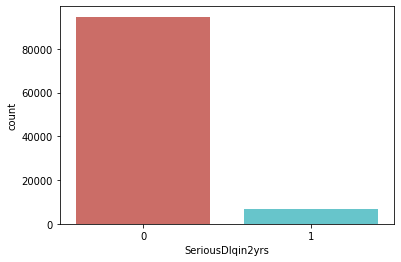

Le pourcentage de défaut de plus de 90 jours les deux dernières année est de  6.670738795897658
Le pourcentage non défaut de plus de 90 jours les deux dernières année est de  93.32926120410234


In [19]:
sns.countplot(x=target, data=dataset,palette='hls')
plt.show()

count_defaut=len(dataset[target==1])
count_no_defaut=len(dataset[target==0])

pct_defaut=count_defaut*100/(count_defaut+count_no_defaut)
print("Le pourcentage de défaut de plus de 90 jours les deux dernières année est de ", pct_defaut)

pct_no_defaut=count_no_defaut*100/(count_defaut+count_no_defaut)
print("Le pourcentage non défaut de plus de 90 jours les deux dernières année est de ", pct_no_defaut)

***Nos classes sont déséquilibrées et le ratio entre les personnes en défaut de plus de 90 jours les deux dernières année est d'environ 7% dans notre échantillon*** qui représente un ratio assez faible pour notre étude

Avant d'aller plus loins pour essayer d'équilibrer nos classes, faisons un peu plus d'exploration!

***Compréhension des variables du dataset***

In [20]:
dataset.groupby(target).mean()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Probability
SeriousDlqin2yrs,,,,,,,,,,,
0,6.224580,52.712779,0.289258,358.808223,6711.904995,8.484620,0.144523,1.022421,0.135329,0.745832,0.067516
1,3.024987,45.907842,2.330527,305.889020,5597.544141,7.864717,2.031015,0.977847,1.771969,0.924523,0.069739


A première vue, on remarque :
- les "default" ont en moyenne 45.90 ans et plus jeunes que ceux "no_default"
- Le ratio "defaut" ont un petit RevolvingUtilizationOfUnsecuredLines
- Il n'y a pas de différence de probabilité (score interne) entre les deux catégiries


**Datavisualisation des relations avec la target**

In [21]:
 X = dataset.iloc[:,1:]
X.mean()

RevolvingUtilizationOfUnsecuredLines       6.011143
age                                       52.258840
NumberOfTime30-59DaysPastDueNotWorse       0.425426
DebtRatio                                355.278121
MonthlyIncome                           6635.148348
NumberOfOpenCreditLinesAndLoans            8.443268
NumberOfTimes90DaysLate                    0.270366
NumberRealEstateLoansOrLines               1.019448
NumberOfTime60-89DaysPastDueNotWorse       0.244505
NumberOfDependents                         0.757856
Probability                                0.067664
dtype: float64

In [22]:
y = dataset.iloc[:,0]
y.head()

0    1
1    0
2    0
3    0
4    0
Name: SeriousDlqin2yrs, dtype: int64

Fonction plot_data

In [23]:
# Préparation du dataset
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convertir le dataset en deux variables
    X: data columns
    y: target
    """
    X = dataset.iloc[:,1:].values
    y = dataset.iloc[:,0].values
    return X, y

In [24]:
# Definir la fonction pour créer le scatter plot de notre dataset
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="no_default #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="default #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [25]:
# Créer les variables X et y à partir de la fonction prep_data
X, y = prep_data(dataset)

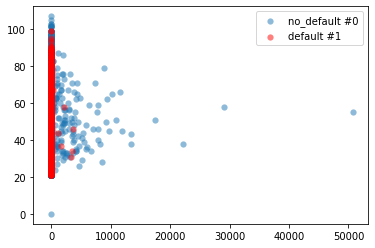

In [26]:
# Tracez nos données en exécutant notre fonction de données sur X et y
plot_data(X, y)

***Corrélation entre les variables et la target***

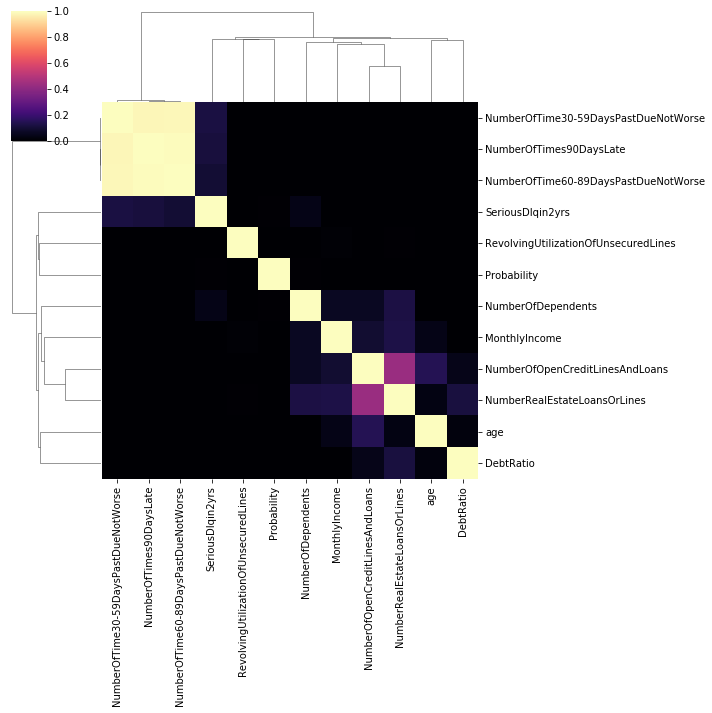

In [27]:
sns.clustermap(dataset.corr(), cmap="magma", vmin=0)

Il existe une co-corrélation importantes entre plusieurs variables dépendantes:
- NumberOfTime 30-59, 60-89 et 90-+
Pour notre analyse, nous garderont celle qui à la plus forte corrélation avec la target soit NumberOfTime30-59DaysPastDueNotWorse. Cela montre que les personnes qui commencent a avoir des incidents sont les plus susceptibles d'être en défaut dans les années à venir

In [28]:
dataset.corr()["SeriousDlqin2yrs"].sort_values()

age                                    -0.115001
NumberOfOpenCreditLinesAndLoans        -0.030126
MonthlyIncome                          -0.020472
NumberRealEstateLoansOrLines           -0.009846
DebtRatio                              -0.006274
RevolvingUtilizationOfUnsecuredLines   -0.003068
Probability                             0.005021
NumberOfDependents                      0.040088
NumberOfTime60-89DaysPastDueNotWorse    0.096983
NumberOfTimes90DaysLate                 0.111450
NumberOfTime30-59DaysPastDueNotWorse    0.119908
SeriousDlqin2yrs                        1.000000
Name: SeriousDlqin2yrs, dtype: float64

----------------

# III/ PRE-PROCESSING

## Objectif: transformer le data pour le mettre dans un format propice au machine learning

## Gestion des valeurs manquante avec IMPUTE

In [29]:
#Nous pouvons changer les valeurs manquantes pour l'ensemble du dataset 
## en leurs moyenne des colonnes individuelles
import numpy as np
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(dataset)

# Intégration des données entrainés dans notre dataset
dataset = pd.DataFrame(imp_mean.transform(dataset),columns=dataset.columns)

In [30]:
X, y = prep_data(dataset)

## Normalisation du dataset

***Feature scaling - Normalisation***

In [31]:
# Nous travaillerons avec les variables transformées
# Normalisation des nouvelles variables explicatives
## Normalisation de X

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

## Décomposition du dataset en train et en test & Modelisation

***Séparation du dataset en variable explicative et target***
***Dataset non équilibré et pris en l'état***

In [32]:
# Division du dataset en train et un test set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=10)

***Fonction de train et de prédiction***

In [33]:
# Fonction de training du model avec les meilleurs paramatères
def train_model(X_train, y_train):
    # Split du train pour 5 validation
    sss = StratifiedShuffleSplit(n_splits=5, random_state=0)
    # Logistic Regression
    model = LogisticRegression(solver='liblinear')
    # Random grid search on hyperparameters
    params = {"penalty": ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}
    '''
    Pour optimiser le score de précision de rappel (score de précision moyen)
    AP résume une courbe précision-rappel comme la moyenne pondérée des précisions 
    atteint à chaque seuil, avec l'augmentation du rappel par rapport à la 
    précédente seuil utilisé comme poids
    '''
    scoring = {'ave_prec': 'average_precision'}
    grid_search = RandomizedSearchCV(model, 
                                  params, 
                                  scoring=scoring,
                                  random_state= 50,
                                  refit='ave_prec', 
                                  cv=sss,
                                  n_iter=6,
                                  verbose=1,
                                  n_jobs=-1)
    
   
    lr_fit = grid_search.fit(X_train, y_train)
    lr_best = grid_search.best_estimator_

    print('Best parameters for model: {}'.format(lr_fit.best_params_))
    print('Best precision-recall socre from training: {}'.format(lr_fit.best_score_))
    return lr_best

In [34]:
# Fonction de prédiction
def predict_test(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    conf_matrix=confusion_matrix(y_test, y_test_pred)
    rocauc_score=roc_auc_score(y_test, y_test_pred) 
    classif_report=classification_report(y_test, y_test_pred)
    

    print(conf_matrix)
    print(rocauc_score)
    print(classif_report)
    sns.heatmap(conf_matrix, annot=True,fmt="d", annot_kws={"size": 16})
    
    # Plot courbe precision-recall
    # Calcul precision-recall pour les différents seuil de probabilite
    precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))
    plt.figure(figsize=(12,6))
    plt.plot(recall, precision, c='b' )
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    pr_score = average_precision_score(y_test, model.decision_function(X_test))
    plt.title('Test PR curve: \n Average Precision-Recall Score ={0:0.2f}'.format(pr_score, fontsize=14))
    plt.grid(b=True, which='major', c='g', linestyle='-', alpha=0.2)
    plt.show()
    
    
    # Plot ROC AUC
    logit_roc_auc = roc_auc_score(y_test, y_test_pred)
    fp, tp, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(12,6))
    plt.plot(fp, tp, label='Regression Logistique (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Faux Positive')
    plt.ylabel('Vrai Positive')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [35]:
#Fonction d'ajustement du poids de l'algorithme de ML
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):

    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

## 1/ Prédiction du modèle sans OVERSAMPLING

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Best parameters for model: {'penalty': 'l1', 'C': 100}
Best precision-recall socre from training: 0.23977858871630953
[[18906    41]
 [ 1301    53]]
0.5184896741037485
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     18947
         1.0       0.56      0.04      0.07      1354

    accuracy                           0.93     20301
   macro avg       0.75      0.52      0.52     20301
weighted avg       0.91      0.93      0.91     20301



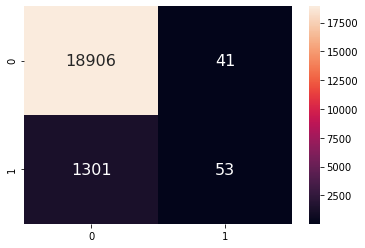

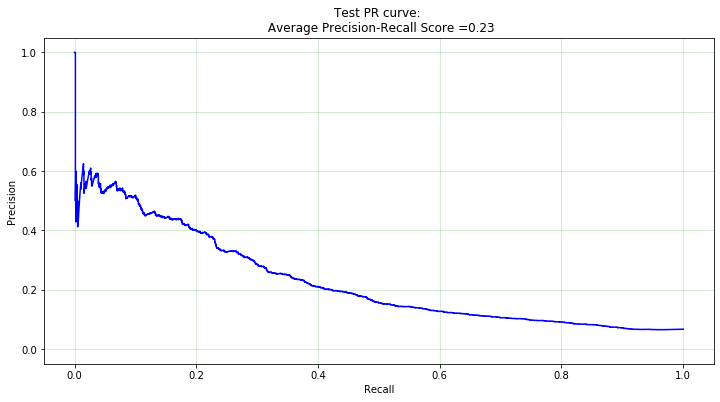

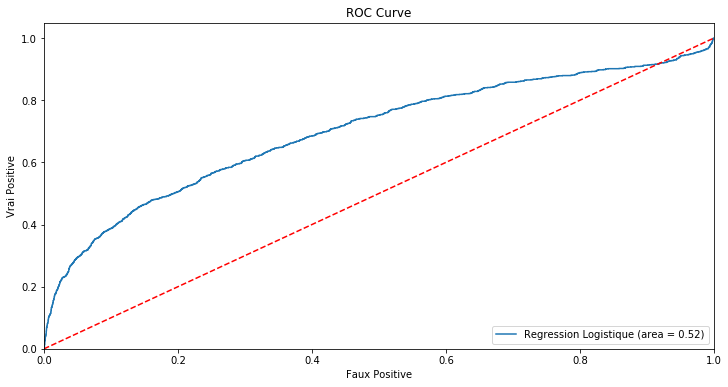

In [36]:
#Train and test dataset déséquilibré
model_regular = train_model(X_train, y_train)
predict_test(model_regular, X_test, y_test)

***Ce modèle ne permet pas de prédire de la meilleure des manières les difficultés financières de clients sous deux années vu le nombre important de faux négatif qui est ici de 1301 malgré l'accuracy et le recall de plus de 90%***

In [40]:
# Ajustement du poids de l'algo de ML sans oversampling RandomForestClassifier
model_reg = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Change depth of model
                               max_depth=10,
                               # Change the number of samples in leaf nodes
                               min_samples_leaf=10, 
                               # Change the number of trees to use
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model_reg)

ROC Score:
0.8544904159694785

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91     18947
         1.0       0.25      0.69      0.37      1354

    accuracy                           0.84     20301
   macro avg       0.61      0.77      0.64     20301
weighted avg       0.93      0.84      0.87     20301


Confusion Matrix:
[[16160  2787]
 [  422   932]]


***La précision de ce modèle RandomForestClassifier est meilleure que le premier modèle même si l'accuracy et le recall est moindre car nous avons un nombre moins important de FN***

*En raison des enregistrements de défaut très limités dans l'ensemble de données de training, notre modèle ne peut détecter que 3% des défauts, tandis que la précision est très élevée en raison du nombre de personnes qui ne sont pas en défaut et qui dominent l'ensemble de données.*

## 2/ Dataset SMOTE OVERSAMPLING

*le SMOTE (Synthetic Minority Over-sampling Technique) permet d'augmenter le nombre de variable en défaut et minoritaire de notre dataset en produisant des exemples synthétiques. Après avoir appliqué la technique SMOTE, le nombre d'instances de défaut dans notre ensemble de données de train est le même que le nombre d'instances normales soit 75785*

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished


Best parameters for model: {'penalty': 'l1', 'C': 1}
Best precision-recall socre from training: 0.7802548898534774
[[14177  4770]
 [  467   887]]
0.7016705582913825
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84     18947
         1.0       0.16      0.66      0.25      1354

    accuracy                           0.74     20301
   macro avg       0.56      0.70      0.55     20301
weighted avg       0.91      0.74      0.80     20301



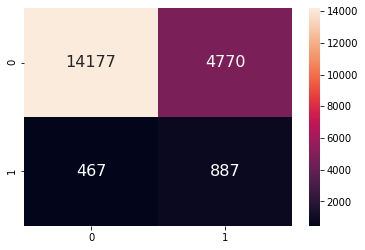

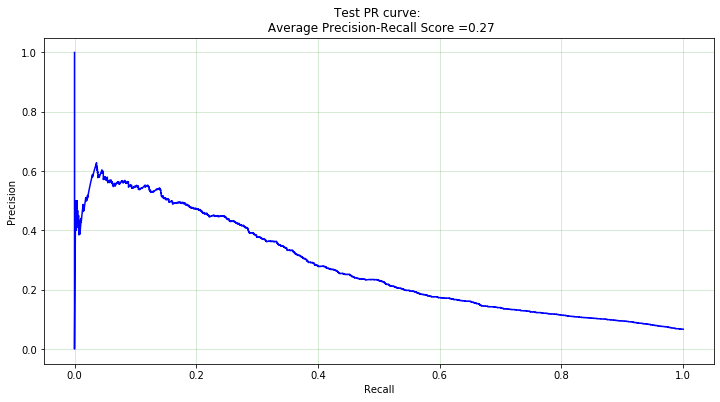

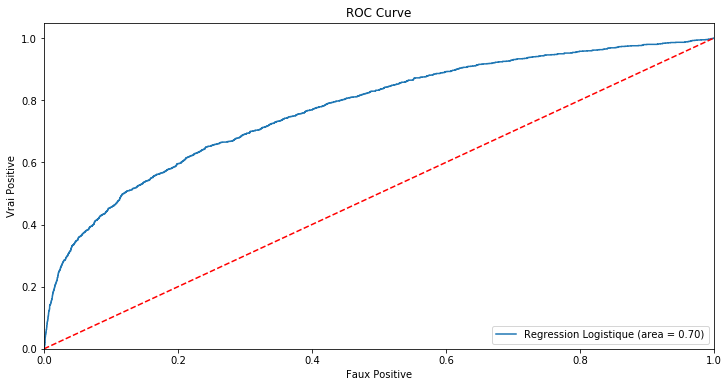

In [41]:
# SMOTE (Synthetic Minority Over-sampling Technique) 
X_train_smote, y_train_smote = SMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)
model_smote = train_model(X_train_smote, y_train_smote)
predict_test(model_smote, X_test, y_test)

***Pour ce modèle rééchantillonné, En raison des enregistrements de défaut très limités dans l'ensemble de données de training, notre modèle permet d'obtenir d'excellente valeurs : accuracy, recall, F-score et une nombre de FN acceptable***
